# 图像定位与分割

In [86]:
from lxml import etree  ##etree是一个非常好的网页解析模块，速度是最快的，也非常的简单,填写一个路径进去，就能找到页面中指定的信息。
from matplotlib.patches import Rectangle#用来绘制正方形（把头在图像上按正方形画出来）
import glob
from PIL import Image#帮我们读取图像

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import os

In [87]:
pil_img=Image.open(r'D:/数据集/宠物数据集/dataset/images/Abyssinian_1.jpg')#先读入图片
np_image=np.array(pil_img)#并将其转化为ndarray的形式
xml=open(r'D:\数据集\宠物数据集\dataset\annotations\xmls\Abyssinian_1.xml','r').read()# 读取第一个图片的xml文件

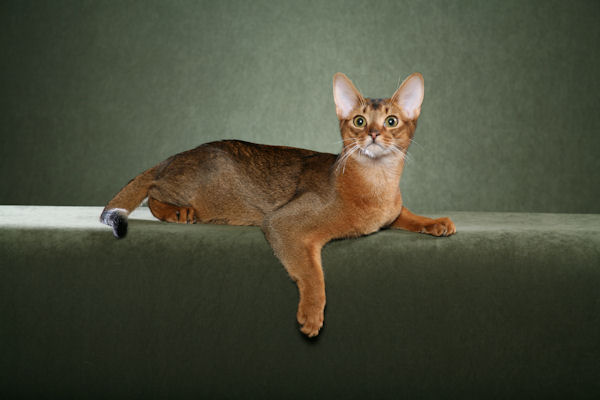

In [88]:
pil_img

In [89]:
sel=etree.HTML(xml) #使用etree来获取信息。想创建一个html格式的选择器。

In [90]:
width=int(sel.xpath('//size/width/text()')[0])#//代表从根目录开始查，一级一级的查到width，text（）代表要获得文本信息，[0]代表只取数值
height=int(sel.xpath('//size/height/text()')[0])#以下同理获取到想要的信息。
xmin=int(sel.xpath('//bndbox/xmin/text()')[0])#转成整形方便后面绘图
xmax=int(sel.xpath('//bndbox/xmax/text()')[0])
ymin=int(sel.xpath('//bndbox/ymin/text()')[0])
ymax=int(sel.xpath('//bndbox/ymax/text()')[0])

In [91]:
width,height,xmin,xmax,ymin,ymax

(600, 400, 333, 425, 72, 158)

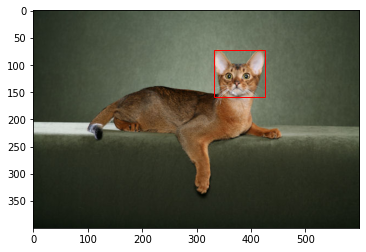

In [92]:
plt.imshow(np_image)
rect=Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')#画矩形的三个参数为(xmin,ymin),宽度以及高度,不需要填充
ax=plt.gca()#因为在当前坐标系上绘制，所以先获取当前坐标系
ax.axes.add_patch(rect)#在当前坐标系下添加矩形框

In [93]:
img=pil_img.resize((224,224))

In [94]:
xmin=(xmin/width)*224
ymin=(ymin/height)*224
xmax=(xmax/width)*224
ymax=(ymax/height)*224

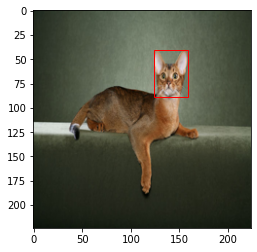

In [95]:
plt.imshow(img)
rect=Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')#画矩形的三个参数为(xmin,ymin),宽度以及高度,不需要填充
ax=plt.gca()#因为在当前坐标系上绘制，所以先获取当前坐标系
ax.axes.add_patch(rect)#在当前坐标系下添加矩形框

In [96]:
images=glob.glob(r'D:/数据集/宠物数据集/dataset/images/*.jpg')#获取所有图像目录
anno=glob.glob(r'D:\数据集\宠物数据集\dataset\annotations\xmls\*.xml')#获取所有标签目录

In [97]:
len(images),len(anno)

(7390, 3686)

In [98]:
xml_name=[x.split('\\')[-1].replace('.xml','') for x in anno]#首先对地址通过 // 拆开取最后一项再将后缀替换为空，对标签中的所有地址进行这个操作

In [99]:
len(anno),len(images)

(3686, 7390)

In [85]:
imgs=[x for x in images if x.split('\\')[-1].replace('.jpg','') in xml_name]

In [43]:
len(imgs),len(anno)

(3686, 3686)

In [44]:
def to_labels(path):#定义一个函数来进行xml中的标签的提取
    xml=open(r'{}'.format(path)).read() #这么做防止输入的字符串转义
    sel=etree.HTML(xml)
    width=int(sel.xpath('//size/width/text()')[0])
    height=int(sel.xpath('//size/height/text()')[0])
    xmin=int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax=int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin=int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax=int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width,ymin/height,xmax/width,ymax/height] #这样返回的是一组值的数，每一个标签返回一组数

In [45]:
labels=[to_labels(p) for p in anno]

In [46]:
l1,l2,l3,l4=list(zip(*labels))

In [47]:
index=np.random.permutation(len(imgs))    
images=np.array(imgs)[index]     
#labels=np.array(labels).astype(np.float32)[index] #因为标签数据是用的除法，所以最好转化以下数据类型。    

In [48]:
out1 = np.array(l1).astype(np.float32).reshape(-1, 1)[index]
out2 = np.array(l2).astype(np.float32).reshape(-1, 1)[index]
out3 = np.array(l3).astype(np.float32).reshape(-1, 1)[index]
out4 = np.array(l4).astype(np.float32).reshape(-1, 1)[index]

In [49]:
i=int(len(imgs)*0.8)

In [50]:
train_imgs=images[:i]
l1_train=out1[:i]
l2_train=out2[:i]
l3_train=out3[:i]
l4_train=out4[:i]

text_imgs=images[i:]
l1_text=out1[i:]
l2_text=out2[i:]
l3_text=out3[i:]
l4_text=out4[i:]

In [51]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [52]:
class Oxford_dataset(data.Dataset):
    def __init__(self, img_paths, out1_label, out2_label, 
                       out3_label, out4_label, transform):
        self.imgs = img_paths
        self.out1_label = out1_label
        self.out2_label = out2_label
        self.out3_label = out3_label
        self.out4_label = out4_label
        self.transforms = transform
        
    def __getitem__(self, index):
        img = self.imgs[index]
        out1_label = self.out1_label[index]
        out2_label = self.out2_label[index]
        out3_label = self.out3_label[index]
        out4_label = self.out4_label[index]
        pil_img = Image.open(img) 
        imgs_data = np.asarray(pil_img, dtype=np.uint8)
        if len(imgs_data.shape) == 2:
            imgs_data = np.repeat(imgs_data[:, :, np.newaxis], 3, axis=2)
            img_tensor = self.transforms(Image.fromarray(imgs_data))
        else:
            img_tensor = self.transforms(pil_img)
        return (img_tensor, 
                out1_label, 
                out2_label, 
                out3_label, 
                out4_label)
    
    def __len__(self):
        return len(self.imgs)



In [53]:
train_ds=Oxford_dataset(train_imgs,l1_train,l2_train,l3_train,l4_train,transform)
text_ds=Oxford_dataset(text_imgs,l1_text,l2_text,l3_text,l4_text,transform)
train_dl=data.DataLoader(train_ds,batch_size=8,shuffle=True)
text_dl=data.DataLoader(text_ds,batch_size=8)

In [54]:
train_dl

In [55]:
(img_batch,out1,out2,out3,out4)=next(iter(train_dl))

C:\ProgramData\Anaconda3\envs\text\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\ProgramData\Anaconda3\envs\text\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


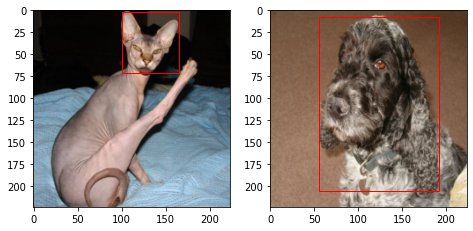

In [56]:
plt.figure(figsize=(12,8))
for i,(img,a1,a2,a3,a4) in enumerate(zip(img_batch[:2],out1[:2],out2[:2],out3[:2],out4[:2])):
    img=img.permute(1,2,0).numpy()
    plt.subplot(2,3,i+1)#一共一行两列
    plt.imshow(img)
    xmin,ymin,xmax,ymax=a1*224,a2*224,a3*224,a4*224 #注意to_labels()函数阿几个比值的返回顺序，要与其一致
    rect=Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
    ax=plt.gca()
    ax.axes.add_patch(rect)

In [57]:
resnet = torchvision.models.resnet101(pretrained=True)

In [58]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [59]:
len(list(resnet.children())) ,list(resnet.children())[-1], list(resnet.children()) #会返回一个所有层的生成器，用list将其返回

(10,
 Linear(in_features=2048, out_features=1000, bias=True),
 [Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1)

In [60]:
list(resnet.children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [61]:
conv_base=nn.Sequential(*list(resnet.children())[:-1])#将除了线性层之外的所有层放入我们的卷积基模型中，使用‘*’将其解包

In [62]:
conv_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [63]:
in_size=resnet.fc.in_features#通过这个获取resnet全连接层的输入参数量

In [64]:
in_size

2048

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()#继承父类的方法
        self.conv_base=nn.Sequential(*list(resnet.children())[:-1])#初始化卷积部分，使用之前迁移学习的卷积基
        self.fc1=nn.Linear(in_size,1)
        self.fc2=nn.Linear(in_size,1)
        self.fc3=nn.Linear(in_size,1)
        self.fc4=nn.Linear(in_size,1)#因为输出了四个坐标值（xmin,ymin,xmax,ymax）所以设置了4个linear层
    def forward(self,x):
        x=self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1=self.fc1(x)
        x2=self.fc2(x)
        x3=self.fc3(x)
        x4=self.fc4(x)
        return x1,x2,x3,x4



In [66]:
model=Net()

In [67]:
if torch.cuda.is_available():
    model.to('cuda')

In [68]:
loss_fn=nn.MSELoss()#因为这是一个回归问题，返回的是一个坐标值，一个具体的数，所以定义的lossfn为这个均方误差

In [69]:
from torch.optim import lr_scheduler
optim=torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler=lr_scheduler.StepLR(optim,step_size=7,gamma=0.1)

In [70]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    running_loss=0
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y1,y2,y3,y4 in trainloader:  
        x,y1,y2,y3,y4=(x.to('cuda'),y1.to('cuda'),y2.to('cuda'),y3.to('cuda'),y4.to('cuda')) #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred1,y_pred2,y_pred3,y_pred4,=model(x)
        loss1=loss_fn(y_pred1,y1)
        loss2=loss_fn(y_pred2,y2)
        loss3=loss_fn(y_pred3,y3)
        loss4=loss_fn(y_pred4,y4)
        loss=loss1+loss2+loss3+loss4
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():                  
            running_loss+=loss.item()          #每一批样本的loss
        
    exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
                                
    text_running_loss=0
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y1,y2,y3,y4  in textloader: 
                x,y1,y2,y3,y4=(x.to('cuda'),y1.to('cuda'),y2.to('cuda'),y3.to('cuda'),y4.to('cuda'))
                y_pred1,y_pred2,y_pred3,y_pred4=model(x)
                loss1=loss_fn(y_pred1,y1)
                loss2=loss_fn(y_pred2,y2)
                loss3=loss_fn(y_pred3,y3)
                loss4=loss_fn(y_pred4,y4)
                loss=loss1+loss2+loss3+loss4                    
                text_running_loss+=loss.item()
                    
    epoch_test_loss=running_loss/len(textloader.dataset)  
        
    
    print('epoch: ', epoch, 
        'loss： ', round(epoch_loss, 3),
        'test_loss： ', round(epoch_test_loss, 3),
            )
        
    return epoch_loss, epoch_test_loss

In [71]:
epochs=5
train_loss=[]
test_loss=[]

In [50]:
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, text_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  0.003 test_loss：  0.013
epoch:  1 loss：  0.001 test_loss：  0.004
epoch:  2 loss：  0.001 test_loss：  0.002
epoch:  3 loss：  0.0 test_loss：  0.001
epoch:  4 loss：  0.0 test_loss：  0.001


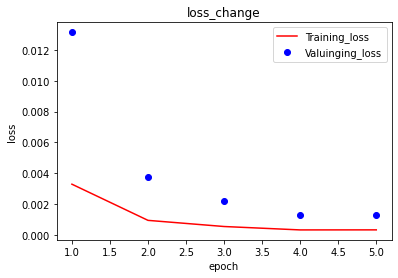

In [53]:
plt.figure()
plt.plot(range(1,len(train_loss)+1),train_loss,'r',label='Training_loss')
plt.plot(range(1,len(test_loss)+1),test_loss,'bo',label='Valuinging_loss')
plt.title('loss_change')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model_save_path='pet_head_model.pth'

In [55]:
torch.save(model.state_dict(),model_save_path)

In [9]:
new_model=Net()

In [11]:
new_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [32]:
new_model.to('cuda')

Net(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

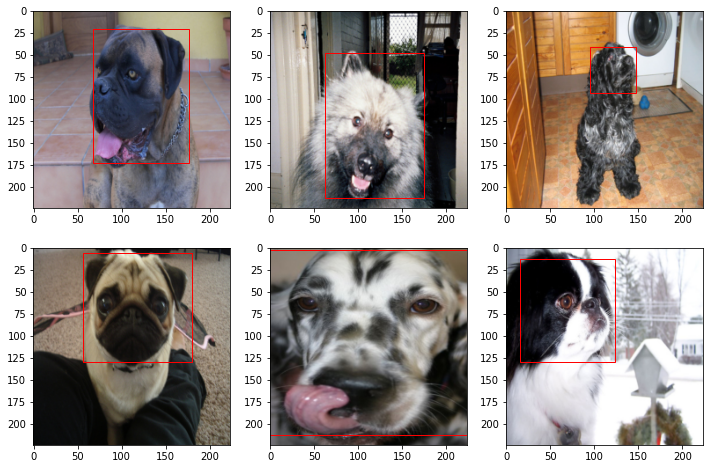

In [35]:
plt.figure(figsize=(12,8))#建一个大点的画布
imgs,_,_,_,_=next(iter(text_dl))#”_“是占位符，只是占一个位置，我们不需要dl中的4个坐标值，我们自己预测，我们只取出图片
if torch.cuda.is_available:
    imgs=imgs.to('cuda')#将这张图片放到显卡中
out1,out2,out3,out4=new_model(imgs)#将这张图片放入模型中会返回四个坐标值
for i in range(6):
    plt.subplot(2,3,i+1)#创建一个六行一列的画布
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = out1[i].item()*224, out2[i].item()*224, out3[i].item()*224, out4[i].item()*224
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)